<a href="https://colab.research.google.com/github/guard1000/SKT_AI_WG/blob/master/wg_text_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **텍스트 분류 예시**

지난 3주간 함께한 VoC sample 데이터를 가지고 분류 예시를 만들어 봅니다.

데이터 수가 매우 적어 학습 성능은 좋지 못하나, 이런 흐름이구나를 이해하는데 도움이 되길 바랍니다.

**[목차]**

1. 데이터 로드

2. 데이터 전처리

3. 학습용, 테스트용 분리 및 데이터 분포 확인

4. 형태소 분석 Tokenizing

5. 단어사전 생성

6. 인덱싱 및 패딩

7. Keras를 활용한 간단한 모델 구현 및 적용


In [ ]:
# 형태소 분석에 활용할 konlpy 설치
!pip install konlpy

     |████████████████████████████████| 19.4MB 59.8MB/s 
     |████████████████████████████████| 3.8MB 47.5MB/s 
     |████████████████████████████████| 92kB 9.1MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

from konlpy.tag import Okt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 엑셀파일 읽어오는 코드. 아래 주소는 엑셀파일의 주소로 변경하세요!
#  -- ex) 엑셀파일이 같은 폴더에 있다면, pd.read_excel("wg_data.xlsx", sheet_name='Sheet1') 
vocs = pd.read_excel("/content/drive/My Drive/data/wg_data.xlsx", sheet_name='Sheet1')
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,[원클릭-양호] -실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,[원클릭-문의 ] 현기 1. 상세증상: 원래 괜찮았는데 일@#@@@@_+주일안쪽으로...,데이터품질
3,"' [CE진단-양호] 시설공급 1. 상세증상: 안테나 2칸 데이터 접속 느림,끊...",데이터품질
4,[원클릭-문의] -일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,CE진단결과 양호 (W- 품질개선가능여부) 1. 상세증상 : 집안에서도 절반정도 통...,음성품질
107,(C- 특이사항) 1. 상세증상 : - 몇개월전부터/ 수신실패/위치무관/ 2....,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


# **전처리 예시**

In [ ]:
# 1. 개행문자 제거 (Slicing)
#    memo 들을 보면 [원클릭-양호] [CE진단-양호] 와 같이 시작하는 녀석들이 존재합니다
#    이 친구들은 실제 메모 내용에 별 의미 없을테니 제거해줍시다.

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  if memos[_][:3].find('[') != -1: # 문장의 앞 3 문자 중 '[' 이 존재한다면
    start =  memos[_].find(']')      # 문장의 ']' 위치를 새로운 시작점으로 변경 
    memos[_] = memos[_][start+1:]    # 텍스트 슬라이싱

vocs['memo'] = memos                 # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,-실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,현기 1. 상세증상: 원래 괜찮았는데 일@#@@@@_+주일안쪽으로 자택에서@#@@...,데이터품질
3,"시설공급 1. 상세증상: 안테나 2칸 데이터 접속 느림,끊김 타사사용자는 양...",데이터품질
4,-일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊김 -데이터도 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,CE진단결과 양호 (W- 품질개선가능여부) 1. 상세증상 : 집안에서도 절반정도 통...,음성품질
107,(C- 특이사항) 1. 상세증상 : - 몇개월전부터/ 수신실패/위치무관/ 2....,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 2. 상세증상 추출 (Slicing)
#    memo 들을 보면 '1.상세증상': ~  와 같은 포맷에 맞춘 메모들이 심심찮게 보입니다.
#    상담유형을 분류하는데 상세증상이 핵심이고, 다른 내용은 noise 이므로 이런 포맷의 메모는
#    상세증상에 해당하는 내용만 추출해 줍시다.

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  if memos[_].find('상세증상') != -1:         # 문장에 '상세증상' 이 포함되 있다면
    start =  memos[_].find('상세증상')        # 문장의 '상세증상' 위치를 새로운 시작점으로 변경
    end = memos[_].find('2.')                   # 보통 위 포맷이 1. 상세증상 ~~ 2. ~~~ 이런 유형이기에... 2 전까지! 
    memos[_] = memos[_][start+5:end]      # 텍스트 슬라이싱

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질%^&^& 및 데이터 끊김 발생됨.,데이터품질
1,-실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일@#@@@@_+주일안쪽으로 자택에서@#@@@@_+만 단말기에서 ...,데이터품질
3,"안테나 2칸 데이터 접속 느림,끊김 타사사용자는 양호 음성통화 정상 단말...",데이터품질
4,-일주%^&^&일전부터 -안테나 안뜨거나 3G 변경되며 음질 끊김 -데이터도 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 ########$안된다고 함 다른데로 이동은 ...,음성품질
106,: 집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,: - 몇개월전부터/ 수신실패/위치무관/,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 3. 특수문자 제거 (정규식)
#    memo 들을 보면 '@#@@@@_+', '########$'와 같은 특수문자 noise가 보입니다. 
#    특수문자는 메모 내용을 파악하는데 noise이므로, 정규식을 활용해 정제해 줍시다

pattern_ex = '[~!@#$%^&*()_+-/:;]' # 이 외에도 지울 대상 변경가능!

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  memos[_] = re.sub(pattern_ex,'',memos[_])  

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs

,memo,label
0,자택과 직장에서 장소상관없이 음질 및 데이터 끊김 발생됨,데이터품질
1,실내외 왔다갔다하면 LTE와 5G번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일주일안쪽으로 자택에서만 단말기에서 LTE라고 떠도 LTE 속도가...,데이터품질
3,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,데이터품질
4,일주일전부터 안테나 안뜨거나 3G 변경되며 음질 끊김 데이터도 잘 안됨 네...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 안된다고 함 다른데로 이동은 못해봐서 다른곳은...,음성품질
106,집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,몇개월전부터 수신실패위치무관,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# 4. 용어 치환 (정규식)
#    불용어(stopword) 제거 및 용어 치환 등에 활용합니다.
#    예를들어, '3G'나 'LTE', '5G' 와 같은 단어들은 결국 유형을 분류하는 목적에서 보면 비슷한 의미이며, 
#    다양한 용어로 표현하기보단 단순하게 표현하는 것이 더 좋은 성능을 보일 수 있습니다.
#    예시로 모두 LTE로 치환시켜 보겠습니다.

pattern_ex = ['3G','5G']

memos = list(vocs['memo']) # 메모만 불러와서
for _ in range(len(memos)):
  for pat_ex in pattern_ex:
    memos[_] = re.sub(pat_ex,'LTE',memos[_]) 

vocs['memo'] = memos                   # vocs 의 memo 컬럼을 전처리한 memos로 대체
vocs    

,memo,label
0,자택과 직장에서 장소상관없이 음질 및 데이터 끊김 발생됨,데이터품질
1,실내외 왔다갔다하면 LTE와 LTE번갈아 잡혀 불량,데이터품질
2,원래 괜찮았는데 일주일안쪽으로 자택에서만 단말기에서 LTE라고 떠도 LTE 속도가...,데이터품질
3,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,데이터품질
4,일주일전부터 안테나 안뜨거나 LTE 변경되며 음질 끊김 데이터도 잘 안됨 ...,데이터품질
...,...,...
105,여기서 30분 전부터 갑자기 통화가 안된다고 함 다른데로 이동은 못해봐서 다른곳은...,음성품질
106,집안에서도 절반정도 통화안되는내용으로 품질확인요청,음성품질
107,몇개월전부터 수신실패위치무관,음성품질
108,며칠전 자택내 수신실패 당일오전 댁내 통화도중 네트워크불안정 문구뜨며 음질끊김 ...,음성품질


In [ ]:
# Shuffle
vocs = vocs.sample(frac=1)  # 셔플
vocs.reset_index(drop=True, inplace=True) # 셔플로 뒤죽박죽이 된 index를 reset해줍니다
vocs

,memo,label
0,오늘 갑자기 다른 SKT 폰은 정상이나 이 폰만 통화권 이탈 유심재장착 해도 동일 ...,음성품질
1,데이터Nate불량 인터넷접속불량,데이터품질
2,평소에 가끔 증상있고 정상이용중 오늘 갑자기 데이터 접속이 안될정도로 느리다고함 ...,데이터품질
3,오늘 오전부터 해당 주민센터 내에 있는 모든 SK고객들 핸드폰이 긴급전화만 된다고...,음성품질
4,10일전부터 통화권이탈 단말점검 권유 후 종료,음성품질
...,...,...
105,안테나 2칸 데이터 접속 느림끊김 타사사용자는 양호 음성통화 정상 단말기...,데이터품질
106,정상이용중 두세달전부터 데이터 연결이 되다 안되다가 함 LTE LTE 어떤 데이터...,데이터품질
107,기기변경 후 자택에서 영상통화 이용불가 음성정상,영상품질
108,23개월됨 음성정상 영상통화안됨 내방안내 하신다고하심 종료,영상품질




**Train, Test set 분리**

In [ ]:
# 20개로 test_data 생성
test_data = vocs[:20]
print(test_data.shape)

# 90개로 train_data 생성
train_data = vocs[20:]
train_data.reset_index(drop=True, inplace=True) 
print(train_data.shape)

display(train_data.head())
display(test_data.head())

(20, 2)
(90, 2)


,memo,label
0,몇일전 소프트웨어 업데이트 후부터 데이터 느림,데이터품질
1,데이터 접속 안되어문의 WIFI OFF후 사용안내,데이터품질
2,장소무관으로 몇일전부터 영상통화가 안된다고 함어플로 하는 통화도 안된다고함,영상품질
3,'발신은되나 수신안됨 문자 발수신은 정상이라고함 같은장소 다른SK고객은 정상임 전원...,음성품질
4,현기지국 어제부터 데이터 LTE LTE 모두 접속불가 통화 정상 건물내 3...,데이터품질


,memo,label
0,오늘 갑자기 다른 SKT 폰은 정상이나 이 폰만 통화권 이탈 유심재장착 해도 동일 ...,음성품질
1,데이터Nate불량 인터넷접속불량,데이터품질
2,평소에 가끔 증상있고 정상이용중 오늘 갑자기 데이터 접속이 안될정도로 느리다고함 ...,데이터품질
3,오늘 오전부터 해당 주민센터 내에 있는 모든 SK고객들 핸드폰이 긴급전화만 된다고...,음성품질
4,10일전부터 통화권이탈 단말점검 권유 후 종료,음성품질


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45936 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 53552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51656 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50689 missing from current font.
  font.set_

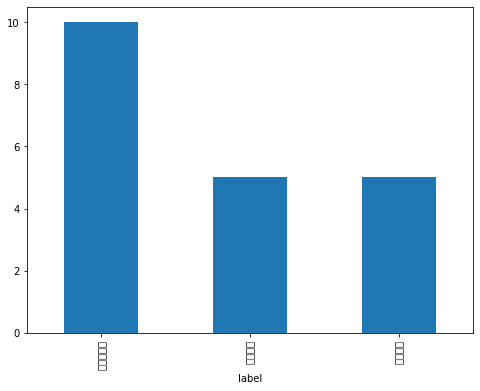

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,6))
test_data.groupby('label').memo.count().plot.bar(ylim=0)

In [ ]:
# 형태소 분석
okt = Okt()
stopwords = ['의','기자', '에','와','한','하다']

X_train = []
X_test = []

# X_train 90개, X_test 20개
for i in range(len(train_data) + len(test_data)):
  sentence = okt.pos(vocs.iloc[i].memo, norm=True, stem=True)
  temp = []
  temp_embedding = []
  all_temp = []
  for k in range(len(sentence)):
    temp_embedding.append(sentence[k][0])

    #if sentence[k][1] not in ["Josa", "Eomi", "Punctuation", "Suffix"] and sentence[k][0] not in stopwords:  
    if sentence[k][1] in ["Noun", "Verb"] and sentence[k][0] not in stopwords:  # 명사와 동사만 써보고 싶을 경우
      temp.append(sentence[k][0]) #+ '/' + sentence[k][1])
  all_temp.append(temp)

  if i < len(train_data):
    train_data.iloc[i].memo = ' '.join(all_temp[0])
    X_train.append(all_temp[0])
  else:
    test_data.iloc[i-len(train_data)].memo = ' '.join(all_temp[0])
    X_test.append(all_temp[0])

test_data.head()

,memo,label
0,영통 음성 정상 초기,음성품질
1,실내 외 오다 가다 오다 번갈아 잡히다 불량,데이터품질
2,변경 후 현상 영상통화 되어다 고함 위치 무관 콜라 영상통화 고함,데이터품질
3,원래 이틀 전 댁 내부 모두 데이터 불량 단말기 버전 설정 여부 사용,음성품질
4,몇 달다 위치 무관 페이스 톡 및 영상통화 끊기다 사무실 함 페이 스톡 확인 시 어...,음성품질


In [ ]:
# Tokenizer로 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
tokenizer.word_index

{'가끔': 57,
 '가다': 47,
 '갑자기': 27,
 '개선': 84,
 '개통': 161,
 '거': 75,
 '건물': 39,
 '걸다': 73,
 '것': 37,
 '계시': 81,
 '고객': 66,
 '고함': 3,
 '관동': 77,
 '군데': 137,
 '권유': 23,
 '기기': 16,
 '기변': 157,
 '긴급': 68,
 '깨다': 147,
 '깨지다': 136,
 '끊기다': 126,
 '나가다': 69,
 '나아지다': 60,
 '나오다': 36,
 '내': 33,
 '내부': 117,
 '다른': 53,
 '단말': 71,
 '단말기': 119,
 '단절': 143,
 '달다': 52,
 '달이': 93,
 '달전': 164,
 '담당자': 85,
 '댁': 116,
 '데이터': 2,
 '동일': 21,
 '되다': 35,
 '되어다': 25,
 '드림': 154,
 '들다': 139,
 '들어오다': 91,
 '뜨다': 10,
 '로': 20,
 '리지': 89,
 '만': 162,
 '몇': 122,
 '모두': 118,
 '모드': 19,
 '모든': 65,
 '무': 131,
 '무관': 17,
 '문의': 92,
 '및': 125,
 '발신': 102,
 '방법': 104,
 '버전': 120,
 '번갈아': 109,
 '벗어나다': 59,
 '변경': 48,
 '보이': 163,
 '보이다': 165,
 '본인': 76,
 '분': 140,
 '분과': 150,
 '불량': 6,
 '비교': 153,
 '사람': 148,
 '사무실': 127,
 '사용': 22,
 '상대방': 145,
 '상전': 94,
 '설정': 24,
 '센터': 64,
 '스톡': 129,
 '시': 43,
 '실': 79,
 '실내': 107,
 '실패': 103,
 '심': 12,
 '쓰다': 160,
 '안내': 105,
 '안테나': 144,
 '애기': 138,
 '어려움': 130,
 '어문': 159,
 '어제': 101

In [ ]:
total_cnt = len(tokenizer.word_index) # 단어사전의 크기
vocab_size = total_cnt + 1 # OOV 고려

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# y_train과 y_test를 지정
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [ ]:
# y_train과 y_test도 str -> float 꼴로 바꿔줌

dic_category = {'데이터품질': 0, '영상품질': 1, '음성품질': 2}
for i in range(len(y_train)):
  y_train[i] = dic_category[y_train[i]]
for i in range(len(y_test)):
  y_test[i] = dic_category[y_test[i]]
  
y_test[-10:]

array([1, 0, 1, 0, 1, 2, 0, 1, 0, 0], dtype=object)

메모 최대 길이 : 36
메모 평균 길이 : 13.811111111111112


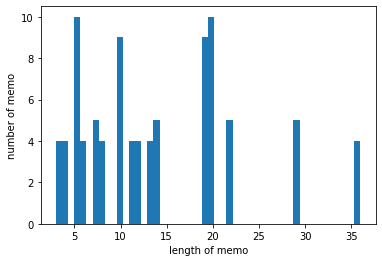

In [ ]:
# 전체 데이터 중 가장 긴 메모, 메모 평균  길이로 어느정도 길이로 잘라낼지 확인
print('메모 최대 길이 :',max(len(l) for l in X_train))
print('메모 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of memo')
plt.ylabel('number of memo')
plt.show()

In [ ]:
#전체 데이터 중 특정 length 이하인 비율을 알려주는 함수

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 데이터 중 길이가 %s 이하인 데이터의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

max_len = 30  # 위 그래프 보면서 임의로 값 넣어보면서 비율 확인
below_threshold_len(max_len, X_train)


전체 데이터 중 길이가 30 이하인 데이터의 비율: 95.55555555555556


In [ ]:
# 모든 데이터의 길이를 앞서 설정한 max_len으로 맞춰줌: padding

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [ ]:
X_test[:3]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        106,  49,   4,  50],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0, 107, 108,  51,  47,
         51, 109, 110,   6],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  48,  13, 111,   5,  25,   3,  26,
         17, 112,   5,   3]], dtype=int32)

In [ ]:
# y_train과 y_test 형변환
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

y_train

array([0., 0., 1., 2., 0., 1., 2., 0., 2., 1., 2., 0., 0., 1., 1., 2., 1.,
       1., 2., 1., 2., 2., 1., 2., 2., 0., 2., 0., 1., 2., 1., 1., 2., 1.,
       0., 2., 2., 2., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 2.,
       0., 0., 2., 2., 1., 0., 0., 0., 1., 2., 1., 0., 2., 2., 2., 2., 0.,
       0., 0., 0., 1., 2., 1., 0., 0., 2., 1., 0., 2., 2., 0., 2., 0., 1.,
       0., 0., 1., 1., 2.], dtype=float32)

# **간단한 모델 적용 예시**

학습 데이터가 90건 정도인 예시이므로, 본 예시에선 유의미한 성능을 내게끔 학습은 X


Ex 1) **LSTM**

In [ ]:
# LSTM 구현 라이브러리 import
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential

In [ ]:
# 모델 제작 
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len)) 
model.add(LSTM(100))
model.add(Dense(3, activation = 'softmax'))

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=4, batch_size=64)

Epoch 1/4
2/2 [==============================] - 0s 19ms/step - loss: 1.0992 - acc: 0.3667
Epoch 2/4
2/2 [==============================] - 0s 15ms/step - loss: 1.0947 - acc: 0.4111
Epoch 3/4
2/2 [==============================] - 0s 14ms/step - loss: 1.0902 - acc: 0.4556
Epoch 4/4
2/2 [==============================] - 0s 14ms/step - loss: 1.0853 - acc: 0.4889


**Ex 2) MLP**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Flatten

model2 = Sequential()
model2.add(Embedding(vocab_size, 100, input_length=max_len))
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(3, activation='softmax'))

model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model2.fit(X_train, y_train, epochs=4, batch_size=64, verbose=1)

Epoch 1/4
2/2 [==============================] - 0s 5ms/step - loss: 1.1002 - accuracy: 0.3889
Epoch 2/4
2/2 [==============================] - 0s 5ms/step - loss: 1.0569 - accuracy: 0.4333
Epoch 3/4
2/2 [==============================] - 0s 5ms/step - loss: 1.0356 - accuracy: 0.4667
Epoch 4/4
2/2 [==============================] - 0s 5ms/step - loss: 1.0149 - accuracy: 0.5111


**참고) Early Stopping과 Model Checkpoint 활용**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# validation_loss가 증가 -> overfitting의 징후이므로, 4회 이상 증가시 학습 조기 종료
# ModelCheckpoint로 val_acc이 전보다 좋아질 경우에만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

#####################  ex) model = Sequential()
####  모델 제작  ####      model.add(Embedding(vocab_size, 100, input_length=max_len)) 
#####################      ...

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# model.fit 에 callbacks 추가
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

**Ex 3) CNN**

In [ ]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Flatten, Dropout
from keras.layers import Conv1D, GlobalMaxPooling1D

model3 = Sequential()
model3.add(Embedding(vocab_size, 100, input_length=max_len))
model3.add(Conv1D(32,
                 8,
                 padding='valid',
                 activation='relu',
                 strides=1))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(3, activation='softmax'))

In [ ]:
# validation_loss가 증가 -> overfitting의 징후이므로, 4회 이상 증가시 학습 조기 종료
# ModelCheckpoint로 val_acc이 전보다 좋아질 경우에만 모델 저장
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
history = model3.fit(X_train, y_train, epochs=8, callbacks=[es, mc], batch_size=64, validation_split=0.25)

Epoch 1/8
1/2 [==============>...............] - ETA: 0s - loss: 1.0976 - acc: 0.3906
Epoch 00001: val_acc improved from -inf to 0.30435, saving model to best_model.h5
2/2 [==============================] - 1s 302ms/step - loss: 1.0973 - acc: 0.3881 - val_loss: 1.1098 - val_acc: 0.3043
Epoch 2/8
1/2 [==============>...............] - ETA: 0s - loss: 1.0852 - acc: 0.4844
Epoch 00002: val_acc did not improve from 0.30435
2/2 [==============================] - 0s 13ms/step - loss: 1.0853 - acc: 0.4925 - val_loss: 1.1157 - val_acc: 0.3043
Epoch 3/8
1/2 [==============>...............] - ETA: 0s - loss: 1.0805 - acc: 0.4844
Epoch 00003: val_acc did not improve from 0.30435
2/2 [==============================] - 0s 12ms/step - loss: 1.0768 - acc: 0.5075 - val_loss: 1.1202 - val_acc: 0.3043
Epoch 4/8
1/2 [==============>...............] - ETA: 0s - loss: 1.0733 - acc: 0.4844
Epoch 00004: val_acc did not improve from 0.30435
2/2 [==============================] - 0s 12ms/step - loss: 1.0692 - 

**Model Checkpont로부터 모델 load 및 활용**

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f6196e35d90>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_test_function.<locals>.test_function at 0x7f6196e35d90>. Note that func